In [1]:
#import sys
#!{sys.executable} -m pip install m2w64-toolchain
import numpy as np
import scipy
from scipy.stats import norm
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def correlations():

    # Load nutrition data
    df_tesco_msoa = pd.read_csv('year_msoa_grocery.csv', encoding='utf-8', header=0)
    df_tesco_ward = pd.read_csv('year_osward_grocery.csv', encoding='utf-8', header=0)
    df_tesco_oslaua = pd.read_csv('year_borough_grocery.csv', encoding='utf-8', header=0)

    # Load health data
    df_child_obesity_ward = pd.read_csv('child_obesity_london_ward_2013-2014.csv', encoding='utf-8', header=0).dropna()
    df_child_obesity_oslaua = pd.read_csv('child_obesity_london_borough_2015-2016.csv', encoding='utf-8', header=0).dropna()
    df_adult_obesity_oslaua = pd.read_csv('london_obesity_borough_2012.csv', encoding='utf-8', header=0).dropna()
    df_adult_obesity_hospital_oslaua = pd.read_csv('obesity_hospitalization_borough_2016.csv', encoding='utf-8',
                                                   header=0).dropna()
    df_diabetes_ward = pd.read_csv('diabetes_estimates_osward_2016.csv', encoding='utf-8', header=0).dropna()

    outfile = open('correlations_health_outcomes.csv', 'wt', encoding='utf-8')
    outfile.write('outcome,nutrient,r,p\n')

    food_indicators = ['energy_tot', 'energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein', 'energy_carb',
                       'energy_fibre', 'h_nutrients_calories_norm']
    food_indicators_labels = ['energy', 'fat', 'saturate', 'sugar', 'protein', 'carb', 'fibre', 'diversity']

    # Correlation with child obesity at Ward level
    df_join = df_tesco_ward.merge(df_child_obesity_ward, how='inner')
    plot_labels = ['Prevalence of overweight\nchildren (reception)', 'Prevalence of overweight\nchildren (year 6)',
                   'Prevalence of obese\nchildren (reception)', 'Prevalence of obese\nchildren (year 6)']
    outcomes = ['prevalence_overweight_reception', 'prevalence_overweight_y6', 'prevalence_obese_reception', 'prevalence_obese_y6']

    for b, lab in zip(outcomes, plot_labels):
        correl = []
        nutrient = []
        for a, al in zip(food_indicators, food_indicators_labels):
            r, p = scipy.stats.spearmanr(df_join[a], df_join[b])
            if p < 0.05:
                outfile.write('%s,%s,%s,%s\n' % (b, al, r, p))
                correl.append(r)
                nutrient.append(al)

    # Correlation with adult obesity
    df_join = df_tesco_oslaua.merge(df_adult_obesity_oslaua, how='inner')
    plot_labels = ['Prevalence of\noverweight adults', 'Prevalence of\nobese adults']
    outcomes = ['f_overweight', 'f_obese']
    for b, lab in zip(outcomes, plot_labels):
        correl = []
        nutrient = []
        for a, al in zip(food_indicators, food_indicators_labels):
            r, p = scipy.stats.spearmanr(df_join[a], df_join[b])
            if p < 0.05:
                # print(b,al,r,p)
                outfile.write('%s,%s,%s,%s\n' % (b, al, r, p))
                correl.append(r)
                nutrient.append(al)

    # Correlation with diabetes estimates
    df_join_diabetes = df_tesco_ward.merge(df_diabetes_ward, how='inner')
    plot_labels = ['Diabetes\nprevalence']
    outcomes = ['estimated_diabetes_prevalence']
    for b, lab in zip(outcomes, plot_labels):
        correl = []
        nutrient = []
        for a, al in zip(food_indicators, food_indicators_labels):
            r, p = scipy.stats.spearmanr(df_join_diabetes[a], df_join_diabetes[b])
            if p < 0.05:
                # print(b,al,r,p)
                outfile.write('%s,%s,%s,%s\n' % (b, al, r, p))
                correl.append(r)
                nutrient.append(al)

    outfile.close()

correlations()

<AxesSubplot:>

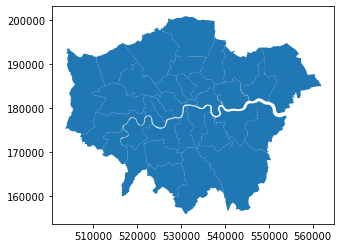

In [3]:
shapefile = "statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(shapefile)
map_df.plot()

In [4]:
df_tesco_oslaua = pd.read_csv('year_borough_grocery.csv', encoding='utf-8', header=0)
df_tesco_oslaua.dtypes

area_id              object
weight              float64
weight_perc2.5      float64
weight_perc25       float64
weight_perc50       float64
                     ...   
age_18_64           float64
age_65+             float64
avg_age             float64
area_sq_km          float64
people_per_sq_km    float64
Length: 202, dtype: object

In [5]:
df_tesco_oslaua = pd.read_csv('year_borough_grocery.csv', encoding='utf-8', header=0)
df_child_obesity_oslaua = pd.read_csv('child_obesity_london_borough_2015-2016.csv', encoding='utf-8', header=0).dropna()
df_adult_obesity_oslaua = pd.read_csv('london_obesity_borough_2012.csv', encoding='utf-8', header=0).dropna()
df_london_sport = pd.read_csv('sports_participation_borough.csv', encoding='utf-8', header=0).dropna()
df_london_edu = pd.read_csv('Qualifications_of_working_age_NVQ.csv', encoding='utf-8', header=0).dropna()
merged = map_df.set_index('GSS_CODE').join(df_tesco_oslaua.set_index('area_id'))
merged = merged.join(df_child_obesity_oslaua.set_index('area_id'))
merged = merged.join(df_adult_obesity_oslaua.set_index('area_id'))
merged.head()

,NAME,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,weight,weight_perc2.5,weight_perc25,...,number_reception_measured,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6,f_healthy_weight,f_overweight,f_obese,weighted_sample
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E09000021,Kingston upon Thames,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",297.379174,30.0,125.0,...,1889.0,1661.0,8.840656,12.763396,5.505558,16.977724,44.4,40.5,14.6,398
E09000008,Croydon,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",353.636123,30.0,150.0,...,4662.0,3985.0,11.304161,14.203262,10.210210,24.717691,36.6,37.7,24.3,858
E09000006,Bromley,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",319.336273,30.0,135.0,...,3815.0,3220.0,12.581914,13.354037,8.020970,16.180124,34.3,43.8,21.2,743
E09000018,Hounslow,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",336.922944,32.5,150.0,...,3465.0,2774.0,10.447330,15.032444,10.274170,24.333093,35.4,41.0,21.8,628
E09000009,Ealing,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",358.569245,35.0,154.0,...,4233.0,3576.0,12.000945,14.681208,10.559887,23.937360,42.1,39.0,18.2,807


In [6]:
df_london_income = pd.read_csv('london_income.csv', encoding='utf-8', header=0).dropna()
merged = merged.set_index('NAME').join(df_london_income.set_index('NAME'))
df_london_sport = pd.read_csv('sports_participation_borough.csv', encoding='utf-8', header=0).dropna()
merged = merged.join(df_london_sport.set_index('NAME'))
df_london_edu = pd.read_csv('Qualifications_of_working_age_NVQ.csv', encoding='utf-8', header=0).dropna()
merged = merged.join(df_london_edu.set_index('NAME'))
merged.head()

,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,weight,weight_perc2.5,weight_perc25,weight_perc50,...,weighted_sample,weekly_income,area_id,par1_perc_2012,par1_pop_2012,par3_perc_2012,par3_pop_2012,par0_perc_2012,par0_pop_2012,qualification_percent
NAME,,,,,,,,,,,,,,,,,,,,,
Kingston upon Thames,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",297.379174,30.0,125.0,220.0,...,398,566.7,E09000021,41.8,55400.0,19.5,25800.0,44.0,58400.0,53.7
Croydon,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",353.636123,30.0,150.0,250.0,...,858,512.3,E09000008,36.8,106000.0,17.4,50100.0,51.5,148600.0,48.1
Bromley,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",319.336273,30.0,135.0,250.0,...,743,584.3,E09000006,41.7,105000.0,18.7,47200.0,45.5,114600.0,48.8
Hounslow,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",336.922944,32.5,150.0,250.0,...,628,500.9,E09000018,32.8,67400.0,16.4,33600.0,52.6,108200.0,50.0
Ealing,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",358.569245,35.0,154.0,275.0,...,807,498.3,E09000009,37.3,100900.0,20.8,56300.0,49.8,134800.0,56.2


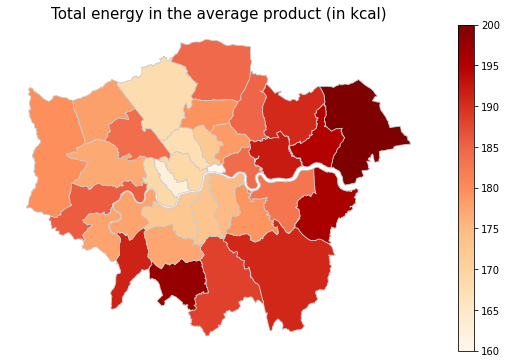

In [7]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='energy_tot', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Total energy in the average product (in kcal)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=160, vmax=200))
sm._A = []
cbar = fig.colorbar(sm)

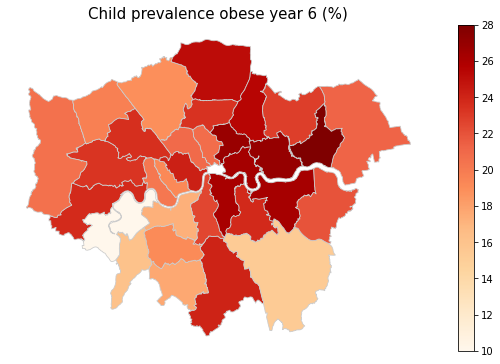

In [8]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='prevalence_obese_y6', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Child prevalence obese year 6 (%)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=10, vmax=28))
sm._A = []
cbar = fig.colorbar(sm)

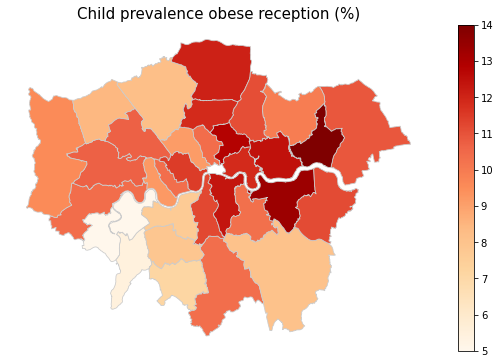

In [9]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='prevalence_obese_reception', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Child prevalence obese reception (%)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=5, vmax=14))
sm._A = []
cbar = fig.colorbar(sm)

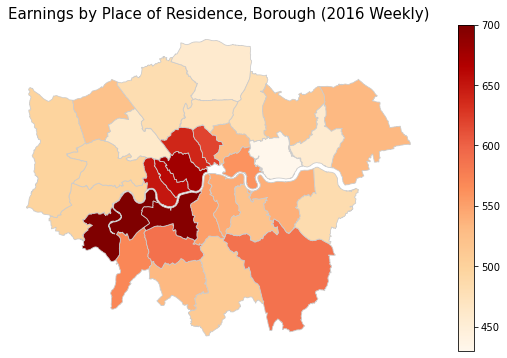

In [10]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='weekly_income', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Earnings by Place of Residence, Borough (2016 Weekly)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=430, vmax=700))
sm._A = []
cbar = fig.colorbar(sm)

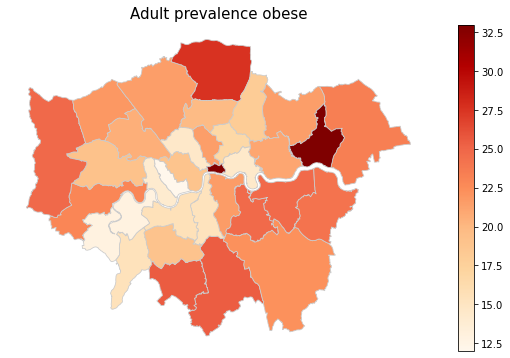

In [11]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='f_obese', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Adult prevalence obese', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=12, vmax=33))
sm._A = []
cbar = fig.colorbar(sm)

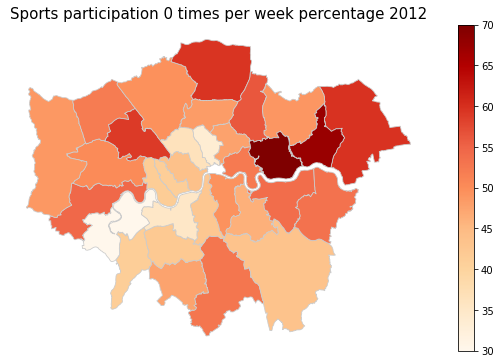

In [12]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='par0_perc_2012', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Sports participation 0 times per week percentage 2012', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=30, vmax=70))
sm._A = []
cbar = fig.colorbar(sm)

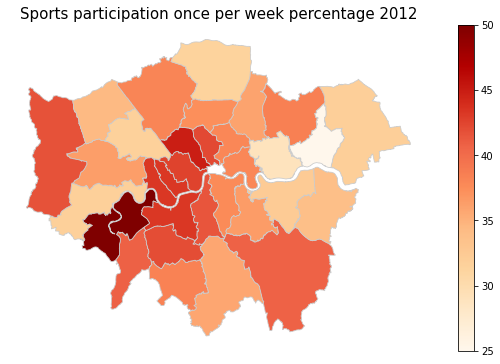

In [13]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='par1_perc_2012', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Sports participation once per week percentage 2012', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=25, vmax=50))
sm._A = []
cbar = fig.colorbar(sm)

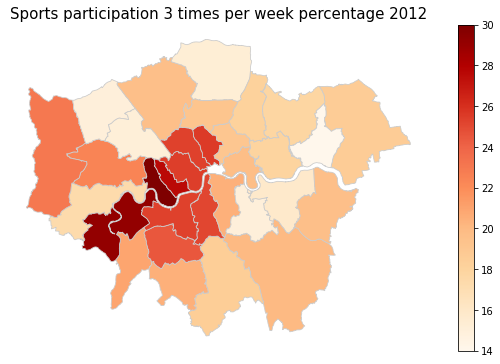

In [14]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='par3_perc_2012', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Sports participation 3 times per week percentage 2012', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=14, vmax=30))
sm._A = []
cbar = fig.colorbar(sm)

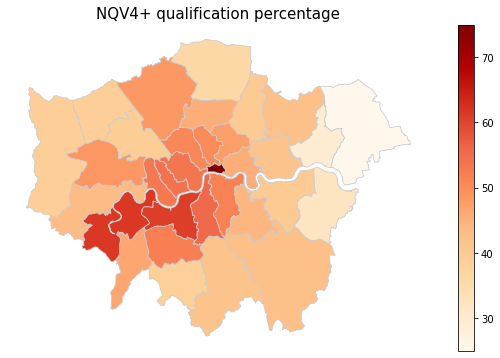

In [15]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='qualification_percent', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('NQV4+ qualification percentage', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=25, vmax=75))
sm._A = []
cbar = fig.colorbar(sm)

# Correlation

In [16]:
data = merged[["energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb", "energy_fibre", "h_nutrients_calories"
              , "prevalence_obese_reception", "prevalence_obese_y6", "f_healthy_weight", "f_overweight", "f_obese", "weekly_income", 
              "par1_perc_2012", "par3_perc_2012", "par0_perc_2012", "qualification_percent"]]
data = data.dropna()
data

,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories,prevalence_obese_reception,prevalence_obese_y6,f_healthy_weight,f_overweight,f_obese,weekly_income,par1_perc_2012,par3_perc_2012,par0_perc_2012,qualification_percent
NAME,,,,,,,,,,,,,,,,,,
Kingston upon Thames,184.954555,83.645165,32.065465,43.881683,21.422725,74.988869,3.248003,1.569158,5.505558,16.977724,44.4,40.5,14.6,566.7,41.8,19.5,44.0,53.7
Croydon,183.154702,81.839970,31.768045,43.877493,20.703677,76.064924,2.973780,1.556777,10.210210,24.717691,36.6,37.7,24.3,512.3,36.8,17.4,51.5,48.1
Bromley,184.657955,82.107490,32.012315,44.874947,20.907180,76.702113,3.027731,1.567786,8.020970,16.180124,34.3,43.8,21.2,584.3,41.7,18.7,45.5,48.8
Hounslow,181.632016,83.368629,32.885357,41.598085,21.132433,72.341016,3.156904,1.568442,10.274170,24.333093,35.4,41.0,21.8,500.9,32.8,16.4,52.6,50.0
Ealing,176.191320,81.109372,32.297035,38.408952,21.473900,68.852826,3.115724,1.580769,10.559887,23.937360,42.1,39.0,18.2,498.3,37.3,20.8,49.8,56.2
Havering,190.274533,83.253226,31.899277,45.821912,21.500878,81.002080,3.111010,1.551112,10.771757,21.951220,36.1,41.0,22.3,532.6,32.9,17.5,55.9,27.8
Hillingdon,177.963153,79.477669,32.444691,40.618328,21.249241,72.370626,3.006661,1.581566,9.459459,21.244310,32.6,43.5,23.7,499.8,42.6,21.3,48.9,44.7
Harrow,176.790789,78.886456,32.088868,40.204457,20.035288,73.404241,3.023350,1.558965,8.402801,20.430966,37.2,38.3,20.8,522.8,35.4,14.4,51.0,44.7
Brent,180.510586,80.662196,32.039220,40.594440,20.531658,74.905905,2.963531,1.555736,10.555265,24.152542,43.9,34.9,19.5,467.0,32.6,14.5,55.4,44.9


In [17]:
data.describe()

,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories,prevalence_obese_reception,prevalence_obese_y6,f_healthy_weight,f_overweight,f_obese,weekly_income,par1_perc_2012,par3_perc_2012,par0_perc_2012,qualification_percent
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,178.878427,80.818550,31.794286,40.164979,21.205819,72.141844,3.038794,1.573589,10.050818,22.599208,41.428125,37.565625,19.43125,545.187500,38.712500,19.268750,48.843750,51.834375
std,5.903391,2.001254,0.818119,2.946583,0.522831,4.648833,0.082596,0.017971,2.054387,3.853827,5.924266,3.115995,4.59982,68.987183,5.203085,3.737468,5.817822,9.981971
min,167.395596,77.350178,30.280712,34.581292,19.932823,62.922095,2.845948,1.531496,5.056433,10.992276,32.600000,31.900000,11.20000,436.700000,26.100000,13.500000,36.800000,27.800000
25%,174.710877,79.206011,31.273273,38.022747,20.923855,68.629953,2.972638,1.558792,8.884620,20.316092,36.475000,35.125000,15.60000,495.475000,35.275000,16.875000,44.850000,45.425000
50%,177.807738,80.591913,31.819773,39.485134,21.233612,72.355821,3.030557,1.573575,10.272796,23.337743,41.650000,37.550000,20.25000,530.200000,38.900000,18.450000,48.950000,51.750000
75%,183.504060,82.177344,32.315652,41.820040,21.585606,75.008296,3.090607,1.586243,11.396533,25.051917,45.300000,40.225000,22.47500,584.550000,42.675000,22.725000,51.900000,59.000000
max,190.274533,84.248027,33.662281,46.516473,22.099482,81.002080,3.248003,1.606432,13.732098,28.487230,52.800000,43.800000,31.60000,688.800000,50.800000,27.300000,62.500000,71.600000


array([[<AxesSubplot:title={'center':'energy_tot'}>,
        <AxesSubplot:title={'center':'energy_fat'}>,
        <AxesSubplot:title={'center':'energy_saturate'}>,
        <AxesSubplot:title={'center':'energy_sugar'}>],
       [<AxesSubplot:title={'center':'energy_protein'}>,
        <AxesSubplot:title={'center':'energy_carb'}>,
        <AxesSubplot:title={'center':'energy_fibre'}>,
        <AxesSubplot:title={'center':'h_nutrients_calories'}>],
       [<AxesSubplot:title={'center':'prevalence_obese_reception'}>,
        <AxesSubplot:title={'center':'prevalence_obese_y6'}>,
        <AxesSubplot:title={'center':'f_healthy_weight'}>,
        <AxesSubplot:title={'center':'f_overweight'}>],
       [<AxesSubplot:title={'center':'f_obese'}>,
        <AxesSubplot:title={'center':'weekly_income'}>,
        <AxesSubplot:title={'center':'par1_perc_2012'}>,
        <AxesSubplot:title={'center':'par3_perc_2012'}>],
       [<AxesSubplot:title={'center':'par0_perc_2012'}>,
        <AxesSubplot:title

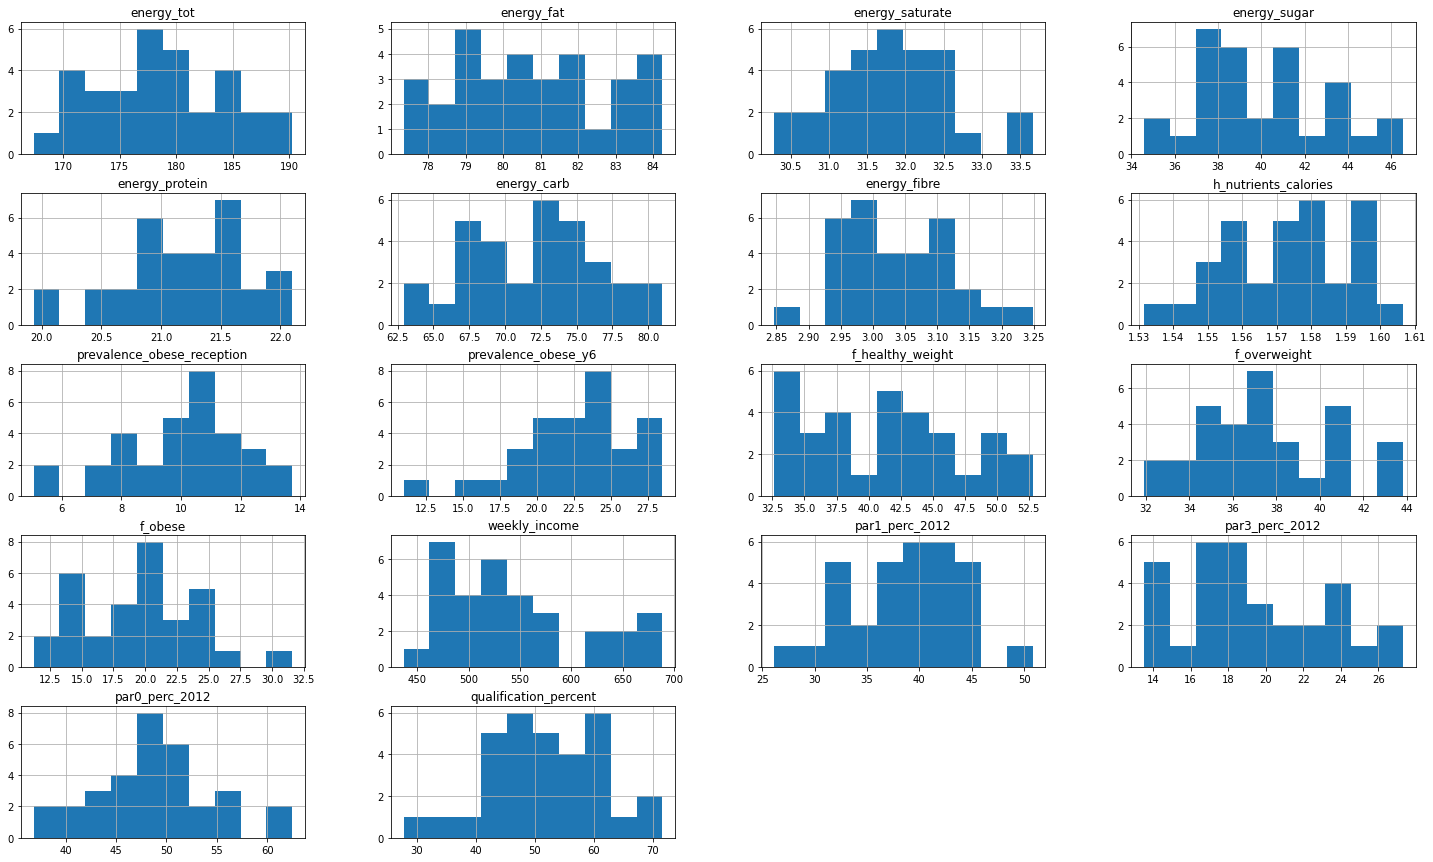

In [18]:
data.hist(figsize=(25,15))

Text(0.5, 1.0, 'Correlation Matrix')

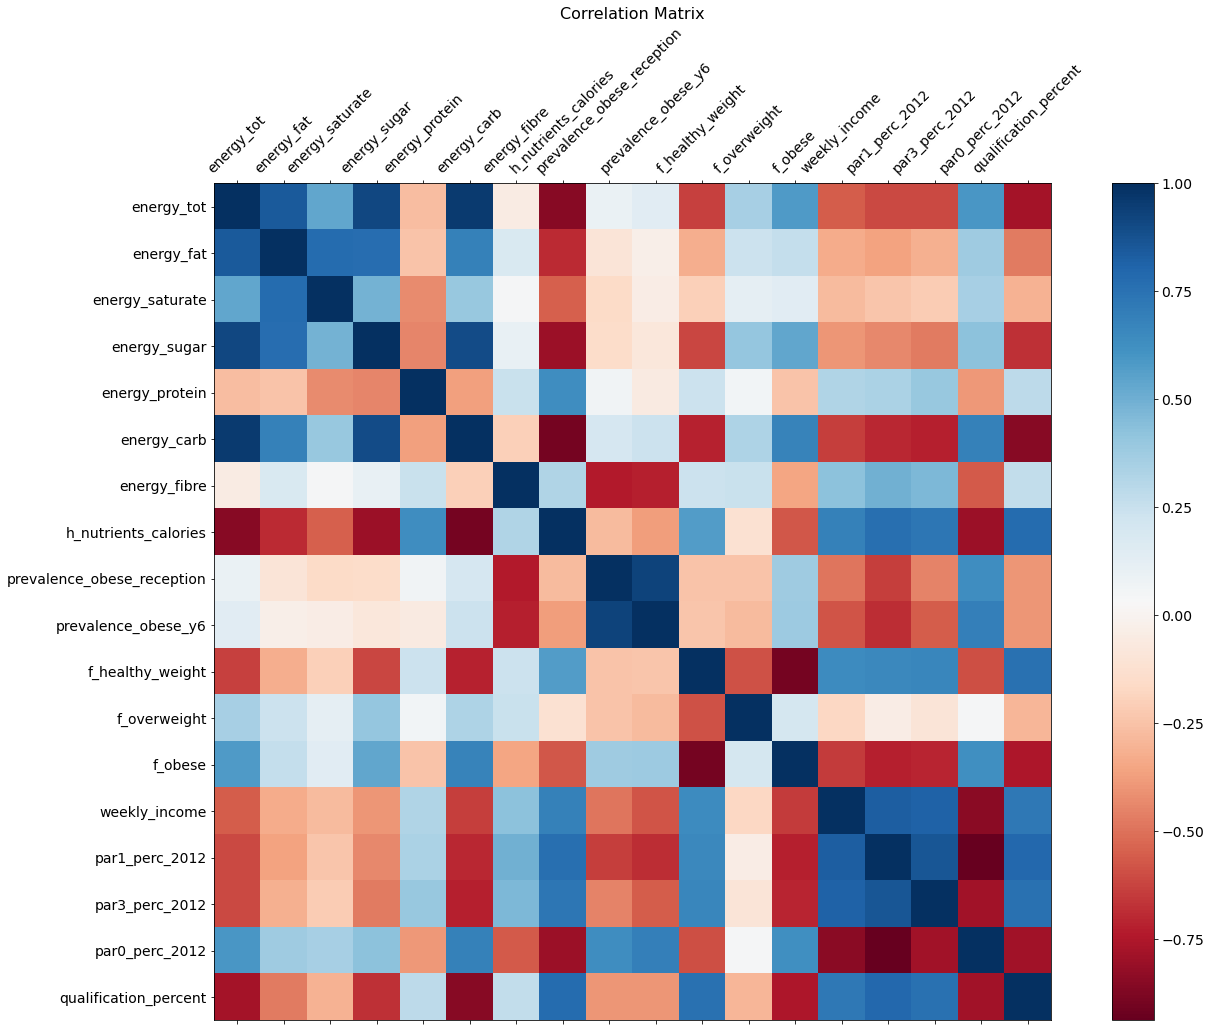

In [19]:
df = data
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(22, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='RdBu')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14,)
plt.title('Correlation Matrix', fontsize=16)

# Linear regression

## intake

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
multi_regression_model_1 = smf.ols(formula='f_obese ~ energy_tot+energy_carb+energy_sugar+energy_protein+energy_fat+energy_saturate+energy_fibre',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     4.550
Date:                Wed, 18 Aug 2021   Prob (F-statistic):            0.00237
Time:                        12:02:25   Log-Likelihood:                -80.217
No. Observations:                  32   AIC:                             176.4
Df Residuals:                      24   BIC:                             188.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.8842     51.765      0.191      0.850     -96.954     116.723
energy_tot          2.1110      5.407      0.390      0.700      -9.048      13.270
energy_carb        -1.1486      5.012     -0.229      0.821     -11.492       9.195
energy_sugar        0.1419      0.968      0.147      0.885      -1.856       2.140
energy_protein     -1.2005      6.805     -0.176      0.861     -15.245      12.844
energy_fat         -3.4306      5.332     -0.643      0.526     -14.436       7.575
energy_saturate     1.3056      1.547      0.844      0.407      -1.887       4.499
energy_fibre       -9.7759     12.326     -0.793      0.435     -35.216      15.664
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   2.585
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.075
Skew:                           0.113   Prob(JB):                        0.963
Kurtosis:                       2.925   Cond. No.                     1.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## output

In [21]:
multi_regression_model_1 = smf.ols(formula='f_obese ~ par0_perc_2012+par3_perc_2012',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     15.41
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           2.76e-05
Time:                        12:02:25   Log-Likelihood:                -82.146
No. Observations:                  32   AIC:                             170.3
Df Residuals:                      29   BIC:                             174.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         25.5394     12.211      2.092      0.045       0.566      50.513
par0_perc_2012     0.1479      0.163      0.905      0.373      -0.186       0.482
par3_perc_2012    -0.6920      0.254     -2.720      0.011      -1.212      -0.172
==============================================================================
Omnibus:                        0.121   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.312
Skew:                           0.101   Prob(JB):                        0.856
Kurtosis:                       2.560   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Stepwise regression

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
def stepwise_selection(X, y, 
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
        """ Perform a forward-backward feature selection 
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features 
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

In [23]:
predictors_data = data.drop(columns=['h_nutrients_calories', 'prevalence_obese_reception', 'prevalence_obese_y6', 'f_healthy_weight', 'f_overweight', 'f_obese', 'qualification_percent', 'weekly_income', 'par0_perc_2012', 'par1_perc_2012', 'par3_perc_2012'], axis=1)
response_data = data['f_obese']
list_predictor_select_stepwise = stepwise_selection(X=predictors_data, y=response_data,initial_list=[], 
                           threshold_in=0.4, 
                           threshold_out = 0.6, 
                           verbose=True)
print("The predictors that are selected by stepwise regression are:")
print(list_predictor_select_stepwise)

Add  energy_carb                    with p-value 2.12661e-05
Add  energy_fat                     with p-value 0.032934
Add  energy_saturate                with p-value 0.369766
The predictors that are selected by stepwise regression are:
['energy_carb', 'energy_fat', 'energy_saturate']


<ipython-input-22-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-22-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-22-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-22-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [24]:
multi_regression_model_1 = smf.ols(formula='f_obese ~ energy_carb+energy_fat+energy_saturate',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     11.46
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           4.46e-05
Time:                        12:02:26   Log-Likelihood:                -80.918
No. Observations:                  32   AIC:                             169.8
Df Residuals:                      28   BIC:                             175.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          20.6164     25.847      0.798      0.432     -32.329      73.562
energy_carb         0.9841      0.181      5.439      0.000       0.613       1.355
energy_fat         -1.3189      0.613     -2.151      0.040      -2.575      -0.063
energy_saturate     1.0822      1.187      0.912      0.370      -1.350       3.514
==============================================================================
Omnibus:                        0.261   Durbin-Watson:                   2.498
Prob(Omnibus):                  0.878   Jarque-Bera (JB):                0.035
Skew:                           0.080   Prob(JB):                        0.983
Kurtosis:                       2.974   Cond. No.                     5.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
multi_regression_model_1 = smf.ols(formula='f_obese ~ energy_fat+energy_sugar+energy_protein+energy_fibre+energy_saturate',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     5.510
Date:                Wed, 18 Aug 2021   Prob (F-statistic):            0.00137
Time:                        12:02:26   Log-Likelihood:                -82.170
No. Observations:                  32   AIC:                             176.3
Df Residuals:                      26   BIC:                             185.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          45.8134     48.588      0.943      0.354     -54.061     145.688
energy_fat         -1.0867      0.837     -1.298      0.206      -2.808       0.634
energy_sugar        1.5209      0.424      3.586      0.001       0.649       2.393
energy_protein      2.1867      1.707      1.281      0.211      -1.322       5.695
energy_fibre      -24.4018      8.149     -2.995      0.006     -41.152      -7.652
energy_saturate     0.8851      1.539      0.575      0.570      -2.278       4.049
==============================================================================
Omnibus:                        0.694   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.230
Skew:                           0.201   Prob(JB):                        0.891
Kurtosis:                       3.100   Cond. No.                     7.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# VIF

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def calculate_vif_(df, thresh=301):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const = add_constant(df)
    cols = const.columns
    variables = np.arange(const.shape[1])
    vif_df = pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df = vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df = vif_df.drop('const')
    vif_df = vif_df[vif_df['VIF'] > thresh]

    print ('Features above VIF threshold:\n')
    print (vif_df[vif_df['VIF'] > thresh])

    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print ('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return df

In [27]:
df_predictors_select_VIF = calculate_vif_(predictors_data)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

Features above VIF threshold:

                     VIF
energy_tot   2688.990272
energy_carb  1432.875129
Dropping: energy_tot
Dropping: energy_carb
The columns remaining after VIF selection are:
Index(['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
       'energy_fibre'],
      dtype='object')


In [28]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X=df_predictors_select_VIF, y=response_data)

regressor_OLS = sm.OLS(endog=response_data, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     5.510
Date:                Wed, 18 Aug 2021   Prob (F-statistic):            0.00137
Time:                        12:02:26   Log-Likelihood:                -82.170
No. Observations:                  32   AIC:                             176.3
Df Residuals:                      26   BIC:                             185.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              45.8134     48.588      0.943      0.354     -54.061     145.688
energy_fat         -1.0867      0.837     -1.298      0.206      -2.808       0.634
energy_saturate     0.8851      1.539      0.575      0.570      -2.278       4.049
energy_sugar        1.5209      0.424      3.586      0.001       0.649       2.393
energy_protein      2.1867      1.707      1.281      0.211      -1.322       5.695
energy_fibre      -24.4018      8.149     -2.995      0.006     -41.152      -7.652
==============================================================================
Omnibus:                        0.694   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.230
Skew:                           0.201   Prob(JB):                        0.891
Kurtosis:                       3.100   Cond. No.                     7.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

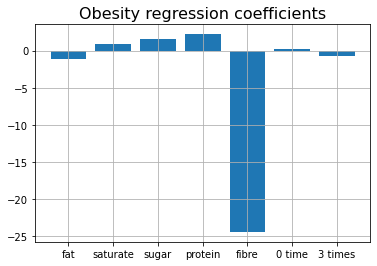

In [29]:
x = np.arange(7)
plt.bar(x, height=[-1.0867,0.8851,1.5209, 2.1867, -24.4018, 0.1479, -0.6920])
plt.xticks(x, ['fat','saturate','sugar', 'protein', 'fibre', '0 time', '3 times'])
plt.title('Obesity regression coefficients', fontsize=16)
plt.grid(True)

# Ward level

In [30]:
df_tesco_osward = pd.read_csv('year_osward_grocery.csv', encoding='utf-8', header=0).dropna()
df_diabetes_osward = pd.read_csv('diabetes_estimates_osward_2016.csv', encoding='utf-8', header=0).dropna()
shapefile = "statistical-gis-boundaries-london/ESRI/London_Ward.shp"
map_df = gpd.read_file(shapefile)
merged1 = map_df.set_index('GSS_CODE').join(df_tesco_osward.set_index('area_id'))
merged1 = merged1.join(df_diabetes_osward.set_index('area_id'))
merged1

,NAME,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,weight,weight_perc2.5,weight_perc25,...,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,gp_patients,gp_patients_diabetes,estimated_diabetes_prevalence
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E05000405,Chessington South,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",255.955618,30.0,96.0,...,5332.0,2465.0,6487.0,1541.0,38.413704,7.55,1389.801325,8722.0,554.0,6.5
E05000414,Tolworth and Hook Rise,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.600 165447.100, 517837.100 16...",289.175712,29.0,115.0,...,5223.0,2391.0,6521.0,1382.0,37.482223,2.59,3974.517375,9030.0,478.0,5.9
E05000401,Berrylands,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.500 167303.400, 518114.300 16...",274.958028,28.0,120.0,...,4767.0,1874.0,6334.0,1500.0,38.388134,1.46,6649.315068,8242.0,393.0,4.9
E05000400,Alexandra,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480.000 166909.800, 520490.700 16...",280.714444,30.0,114.0,...,4872.0,2289.0,5757.0,1593.0,39.444756,2.68,3596.641791,8424.0,489.0,6.3
E05000402,Beverley,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071.000 168144.900, 522063.900 16...",286.984731,25.0,115.0,...,5533.0,2528.0,6716.0,1482.0,37.885232,1.89,5675.132275,9907.0,600.0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000002,Aldgate,11.227,0.0,E09000001,City of London,51182,"POLYGON ((533326.100 181359.400, 533336.900 18...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E05000008,Broad Street,8.188,0.0,E09000001,City of London,50669,"POLYGON ((532703.800 181263.500, 532707.800 18...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E05000012,Coleman Street,15.404,0.0,E09000001,City of London,122520,"POLYGON ((532880.500 181723.400, 532884.200 18...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


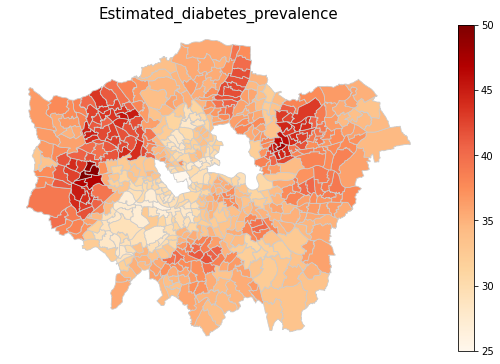

In [31]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged1.plot(column='estimated_diabetes_prevalence', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Estimated_diabetes_prevalence', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=25, vmax=50))
sm._A = []
cbar = fig.colorbar(sm)

In [32]:
data1 = merged1[["energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb", "energy_fibre", "h_nutrients_calories", 
               "estimated_diabetes_prevalence"]]
data1 = data1.dropna()
data1

,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories,estimated_diabetes_prevalence
GSS_CODE,,,,,,,,,
E05000405,204.562112,92.679351,36.658891,52.591598,21.594103,85.683339,3.130338,1.529368,6.5
E05000414,189.805980,84.585911,32.859136,46.716364,21.232969,78.337361,3.027347,1.580672,5.9
E05000401,182.229908,78.661061,28.883246,43.199742,22.073903,76.582152,3.585685,1.580905,4.9
E05000400,187.432175,85.098318,31.864344,45.010630,21.187900,75.675225,3.136919,1.578573,6.3
E05000402,187.305391,82.881532,31.298258,46.309577,20.211212,78.764518,3.237436,1.569431,6.1
...,...,...,...,...,...,...,...,...,...
E05000034,189.106935,81.941024,31.096721,45.096483,21.004818,81.771457,2.863609,1.545616,7.5
E05000042,191.199208,82.440160,31.564497,44.741718,20.697451,83.942690,3.095981,1.528607,8.0
E05000030,188.136201,84.436271,32.531970,45.331593,21.228013,78.325611,2.963643,1.540547,7.3


Text(0.5, 1.0, 'Correlation Matrix')

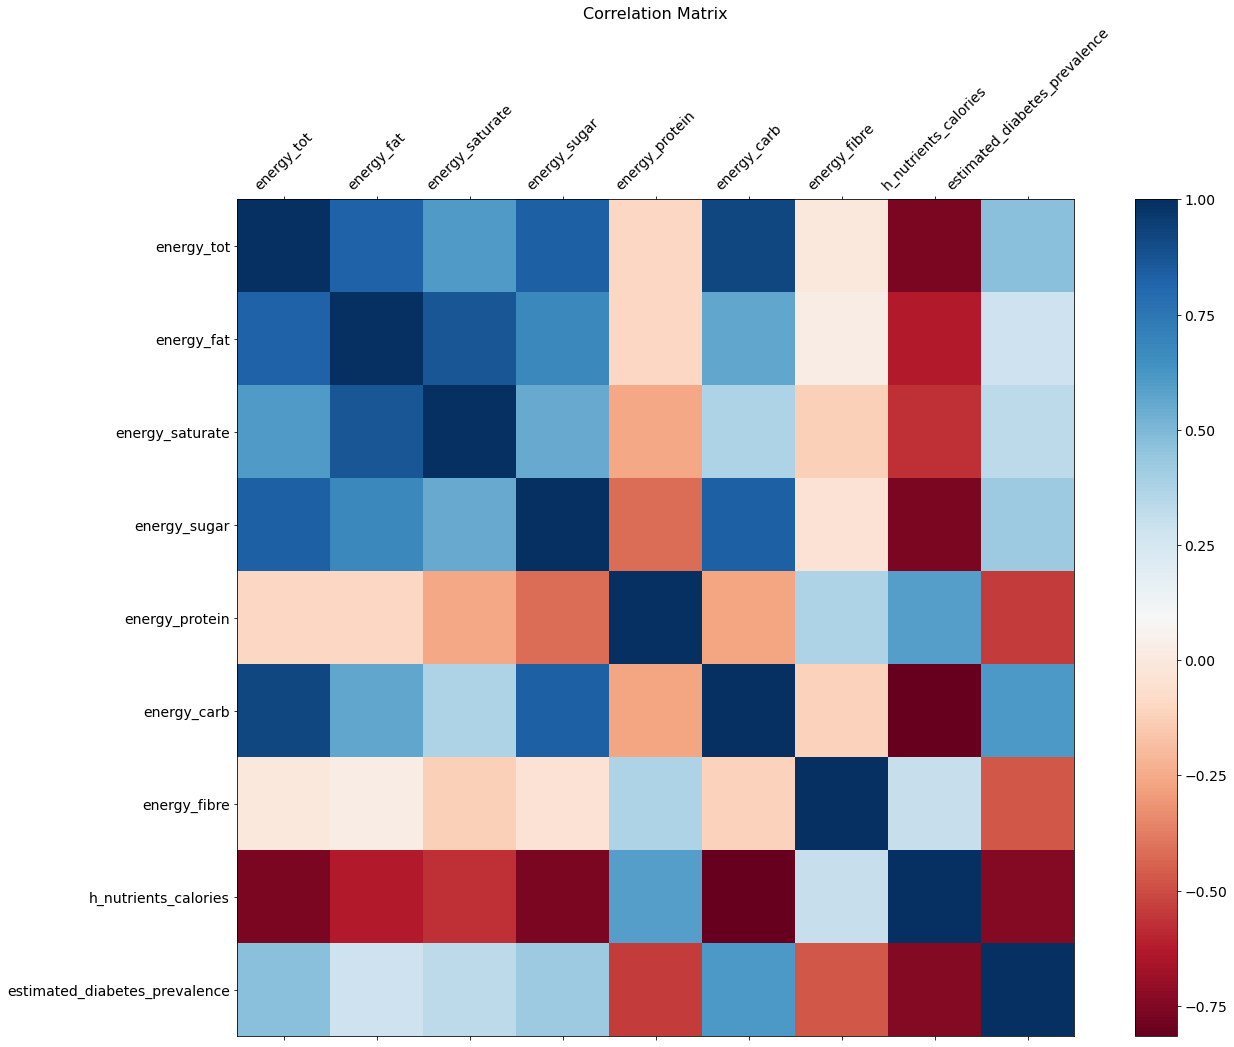

In [33]:
df = data1
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(22, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='RdBu')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14,)
plt.title('Correlation Matrix', fontsize=16)

In [34]:
multi_regression_model_1 = smf.ols(formula='estimated_diabetes_prevalence ~ energy_tot+energy_carb+energy_sugar+energy_protein+energy_fat+energy_saturate+energy_fibre',data=data1).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     estimated_diabetes_prevalence   R-squared:                       0.728
Model:                                       OLS   Adj. R-squared:                  0.724
Method:                            Least Squares   F-statistic:                     181.6
Date:                           Wed, 18 Aug 2021   Prob (F-statistic):          6.35e-130
Time:                                   12:02:27   Log-Likelihood:                -696.00
No. Observations:                            483   AIC:                             1408.
Df Residuals:                                475   BIC:                             1441.
Df Model:                                      7                                         
Covariance Type:                       nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          17.8872      2.013      8.888      0.000      13.932      21.842
energy_tot         -0.7348      0.165     -4.464      0.000      -1.058      -0.411
energy_carb         1.0543      0.156      6.753      0.000       0.747       1.361
energy_sugar       -0.3214      0.030    -10.708      0.000      -0.380      -0.262
energy_protein     -0.1214      0.199     -0.610      0.542      -0.512       0.270
energy_fat          0.6548      0.169      3.884      0.000       0.323       0.986
energy_saturate     0.3879      0.073      5.343      0.000       0.245       0.531
energy_fibre       -1.9649      0.399     -4.927      0.000      -2.749      -1.181
==============================================================================
Omnibus:                       29.093   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.453
Skew:                           0.324   Prob(JB):                     1.66e-14
Kurtosis:                       4.653   Cond. No.                     9.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
multi_regression_model_1 = smf.ols(formula='estimated_diabetes_prevalence ~ energy_tot+energy_carb+energy_sugar+energy_fat+energy_saturate+energy_fibre',data=data1).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     estimated_diabetes_prevalence   R-squared:                       0.728
Model:                                       OLS   Adj. R-squared:                  0.724
Method:                            Least Squares   F-statistic:                     212.1
Date:                           Wed, 18 Aug 2021   Prob (F-statistic):          5.03e-131
Time:                                   12:03:16   Log-Likelihood:                -696.19
No. Observations:                            483   AIC:                             1406.
Df Residuals:                                476   BIC:                             1436.
Df Model:                                      6                                         
Covariance Type:                       nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          17.9582      2.008      8.944      0.000      14.013      21.904
energy_tot         -0.8287      0.059    -14.147      0.000      -0.944      -0.714
energy_carb         1.1423      0.060     19.161      0.000       1.025       1.259
energy_sugar       -0.3135      0.027    -11.585      0.000      -0.367      -0.260
energy_fat          0.7451      0.081      9.233      0.000       0.587       0.904
energy_saturate     0.3902      0.072      5.386      0.000       0.248       0.533
energy_fibre       -1.9302      0.394     -4.893      0.000      -2.705      -1.155
==============================================================================
Omnibus:                       30.083   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.233
Skew:                           0.334   Prob(JB):                     4.15e-15
Kurtosis:                       4.687   Cond. No.                     9.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
def calculate_vif_(df, thresh=15):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const = add_constant(df)
    cols = const.columns
    variables = np.arange(const.shape[1])
    vif_df = pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df = vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df = vif_df.drop('const')
    vif_df = vif_df[vif_df['VIF'] > thresh]

    print ('Features above VIF threshold:\n')
    print (vif_df[vif_df['VIF'] > thresh])

    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print ('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return df

In [38]:
df_predictors_select_VIF1 = calculate_vif_(predictors_data1)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF1.columns)
lr = LinearRegression()
lr.fit(X=df_predictors_select_VIF1, y=response_data1)

regressor_OLS = sm.OLS(endog=response_data1, exog=sm.add_constant(df_predictors_select_VIF1)).fit()
regressor_OLS.summary()

Features above VIF threshold:

                    VIF
energy_tot   716.047851
energy_carb  340.078323
energy_fat   146.701068
Dropping: energy_tot
Dropping: energy_carb
Dropping: energy_fat
The columns remaining after VIF selection are:
Index(['energy_saturate', 'energy_sugar', 'energy_protein', 'energy_fibre'], dtype='object')


AttributeError: 'ScalarMappable' object has no attribute 'OLS'

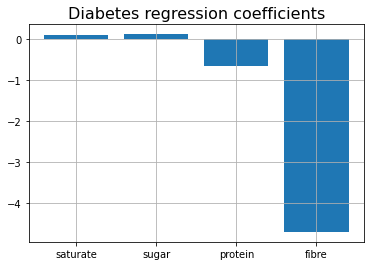

In [39]:
x = np.arange(4)
plt.bar(x, height=[0.1026,0.1218,-0.6544, -4.7078])
plt.xticks(x, ['saturate','sugar', 'protein', 'fibre'])
plt.title('Diabetes regression coefficients', fontsize=16)
plt.grid(True)

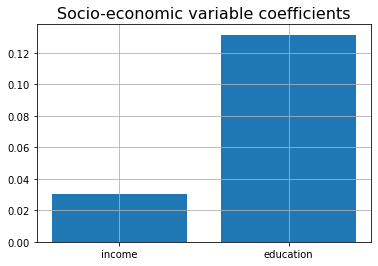

In [40]:
x = np.arange(2)
plt.bar(x, height=[0.0302, 0.1315])
plt.xticks(x, ['income','education'])
plt.title('Socio-economic variable coefficients', fontsize=16)
plt.grid(True)

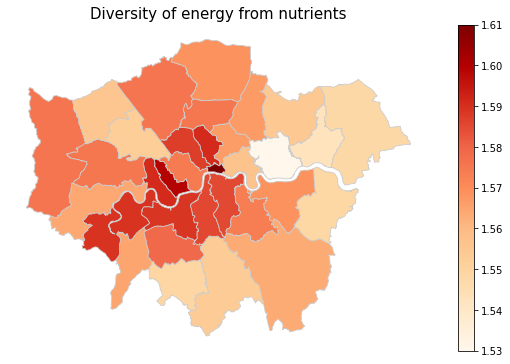

In [41]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='h_nutrients_calories', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Diversity of energy from nutrients', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=1.53, vmax=1.61))
sm._A = []
cbar = fig.colorbar(sm)

In [42]:
multi_regression_model_1 = smf.ols(formula='par3_perc_2012 ~ weekly_income+qualification_percent',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         par3_perc_2012   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     36.85
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           1.09e-08
Time:                        12:03:21   Log-Likelihood:                -66.853
No. Observations:                  32   AIC:                             139.7
Df Residuals:                      29   BIC:                             144.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.0097      2.951     -1.359      0.185     -10.045       2.025
weekly_income             0.0302      0.008      3.893      0.001       0.014       0.046
qualification_percent     0.1315      0.054      2.453      0.020       0.022       0.241
==============================================================================
Omnibus:                        0.121   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.211
Skew:                           0.129   Prob(JB):                        0.900
Kurtosis:                       2.698   Cond. No.                     4.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
multi_regression_model_1 = smf.ols(formula='f_obese ~ h_nutrients_calories',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     14.59
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           0.000624
Time:                        12:03:21   Log-Likelihood:                -87.388
No. Observations:                  32   AIC:                             178.8
Df Residuals:                      30   BIC:                             181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              249.8493     60.319      4.142      0.000     126.661     373.037
h_nutrients_calories  -146.4284     38.330     -3.820      0.001    -224.708     -68.149
==============================================================================
Omnibus:                        0.368   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.512
Skew:                           0.202   Prob(JB):                        0.774
Kurtosis:                       2.530   Cond. No.                         197.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Prevalence obese')

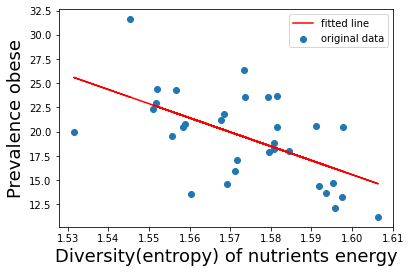

In [45]:
plt.scatter(data['h_nutrients_calories'], data['f_obese'], label='original data')
plt.plot(data['h_nutrients_calories'], 249.8493 -146.4284*data['h_nutrients_calories'], 'r', label='fitted line')
plt.legend()
plt.xlabel('Diversity(entropy) of nutrients energy', fontsize=18)
plt.ylabel('Prevalence obese', fontsize=18)